In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import scipy.io as sio

import gsw as sw

from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset as NetCDFFile

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# import data

#maxlon = 300
#minlon = 179

Tok1 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo1_vSept16.csv', sep = ',')
Tok1['density'] = sw.rho(Tok1['S'].values,Tok1['T'].values,0)
#Tok1 = Tok1[(Tok1['Lon']>minlon) & (Tok1['Lon']<maxlon)]

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]

Tok2 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo2_vSept16.csv', sep = ',')
Tok2['density'] = sw.rho(Tok2['S'].values,Tok2['T'].values,0)

Tok3 = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tokyo3_vSept16.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)
#Tok3 = Tok3[(Tok3['Lon']>minlon) & (Tok3['Lon']<maxlon)]

Tian = pd.read_csv(r'/Users/sclayton/Google Drive/o2ar_data/Tianjin2_vSept16.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)
#Tian = Tian[(Tian['Lon']>minlon) & (Tian['Lon']<maxlon)]

print Tian.columns

Index([u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo', u'TrueO2Ar',
       u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn', u'Air-sea flux',
       u'density'],
      dtype='object')


In [3]:
# load the satellite NPP data

fname = '/Users/sclayton/Google Drive/work/kuroshio_productivity/data/satellite/vgpm/vgpm.2011129.all.xyz'
npp_may11 = pd.read_csv(fname, sep = ' ')

fname = '/Users/sclayton/Google Drive/work/kuroshio_productivity/data/satellite/vgpm/vgpm.2011137.all.xyz'
npp_may11b = pd.read_csv(fname, sep = ' ')

lon = (npp_may11['lon']).values # longitude
lat = (npp_may11['lat']).values # latitude
npp1 = (npp_may11['value']).values # npp
npp2 = (npp_may11b['value']).values # npp

# reshape the data to a 2160x4320 grid
ny = 2160
nx = 4320

LON = lon.reshape(ny,nx)
LAT = lat.reshape(ny,nx)
NPP_may1 = npp1.reshape(ny,nx)
NPP_may2 = npp2.reshape(ny,nx)

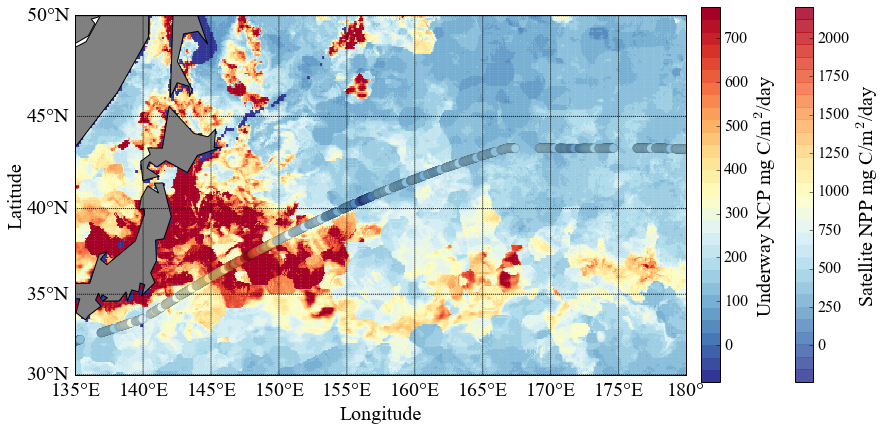

In [17]:
fig2 = plt.figure(2, figsize=(13, 6), dpi = 600)
palette = plt.get_cmap('RdYlBu_r', 30)
m = Basemap(projection='merc',llcrnrlat=30.,urcrnrlat=50.05,\
            llcrnrlon=135,urcrnrlon=180,lat_ts=0,resolution='c')
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')
#plt.axes([0.025, 0.025, 0.95, 0.95])
xm, ym = m(LON, LAT)
#m.plot(xm,ym,'.r')
cax1 = m.pcolormesh(xm, ym, NPP_may1, shading='flat', alpha=.85,lw=0, vmin = -241, vmax = 2200, cmap = palette)

xm, ym = m((Tok1['Lon']).values,(Tok1['Lat']).values)
cax2 = m.scatter(xm, ym, s=75, c=(Tok1['Air-sea flux'].values*(12/1.4)), alpha=1,lw=0.1, vmin = -10*(12/1.4), vmax = 90*(12/1.4), cmap = palette)

m.drawparallels(np.arange(-50,80,5),labels=[1,0,0,0], fontsize=20)
m.drawmeridians(np.arange(-180,180,5),labels=[0,0,0,1], fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xlabel('Longitude', fontsize = 20, labelpad = 30)
plt.ylabel('Latitude', fontsize = 20, labelpad = 50)

cb1 = plt.colorbar(cax1, pad = -0.02)
cb1.ax.tick_params(labelsize=16)
cb1.set_label('Satellite NPP mg C/m$^2$/day', fontsize = 20)

cb2 = plt.colorbar(cax2, pad = 0.02)
cb2.ax.tick_params(labelsize=16)
cb2.set_label('Underway NCP mg C/m$^2$/day', fontsize = 20)
plt.show()

#fig2.savefig('../figures/NPP_NCP_May11_129.png', dpi=600)

In [ ]:
# pull out the satellite NPP data to line up with underway NCP

ncp = Tok1['Air-sea flux'].values

npp2_track = []
npp_track = []
new_lat = []
new_lon = []

x = LON[0,:]
y = LAT[:,0]

xnew = Tok1['Lon'].values
ynew = Tok1['Lat'].values

for n in range(len(xnew)):
    
    k = np.argmin(np.abs(x-xnew[n]))
    llon = x[k]
    l = np.argmin(np.abs(y-ynew[n]))
    llat = y[l]

    m = np.mean(NPP_may1[l,k])
    o = np.mean(NPP_may2[l,k])
    
    if np.isfinite(m) & np.isfinite(l):
        new_lat.append(llat)
        new_lon.append(llon)
        npp_track.append(m)
        npp2_track.append(o)
    else:
        new_lat.append(np.nan)
        new_lat.append(np.nan)
        npp_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(sla_track, ncp_track, s = 20, lw = 0)

dtab = pd.DataFrame()
dtab['npp'] = npp_track
dtab['npp2'] = npp2_track
dtab['lat'] = new_lat
dtab['lon'] = new_lon
dtabT1 = dtab.dropna().drop_duplicates()

dtabT1 = dtabT1[dtabT1['lon']>0]

In [ ]:
fig2, (ax1) = plt.subplots(1, 1, figsize = (12,9), dpi = 300)

ax1.plot(dtabT1['lon'], dtabT1['npp'], '-ok', zorder = 0, label = 'satellite NPP')
ax1.plot(dtabT1['lon'], dtabT1['npp2'], '-o', color = 'grey', zorder = 0, label = 'satellite NPP')

ax8 = ax1.twinx()
ax8.plot(Tok1['Lon'], Tok1['Air-sea flux']*(12/1.4), 'r', lw = 4, alpha = 0.75, label = 'underway NCP')
ax1.axhline(0, c='k', lw = 2)
ax1.set_xlim([130, 170])
ax1.set_ylim([-241, 10000])
ax8.set_ylim([-10*(12/1.4), 100*(12/1.4)])

ax1.set_ylabel('Satellite NPP (VGPM) mg C/m$^2$/day', fontsize = 20, color = 'k')
ax8.set_ylabel('Underway NCP mg C/m$^2$/day', fontsize = 20, color = 'r')

ax1.tick_params(colors='k', labelsize = 20)
ax8.tick_params(colors='r', labelsize = 20)
ax8.set_xlabel('Longitude', fontsize = 20)


In [ ]:
np.max(dtabT1['npp2'])

In [ ]:
plt.plot(dtabT1['lon'], dtabT1['npp2'], '-o', color = 'grey', zorder = 0, label = 'satellite NPP')
plt.plot(dtabT1['lon'], dtabT1['npp'], '-o', color = 'red', zorder = 0, label = 'satellite NPP')
